In [1]:
# Load Libraries
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import SVHN
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline


In [2]:
# Load Data
dataset = SVHN(root='data/', download=True, transform=ToTensor())

Using downloaded and verified file: data/train_32x32.mat


In [3]:
# Split Data
val_size = int(len(dataset)*0.2)
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(58606, 14651)

In [4]:
# Create Data Loaders
batch_size = 32
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)

images.shape: torch.Size([32, 3, 32, 32])
tensor([2, 4, 9, 7, 1, 3, 2, 3, 5, 7, 7, 9, 3, 9, 2, 3, 2, 3, 3, 6, 7, 7, 9, 8,
        6, 1, 2, 6, 2, 1, 8, 1])


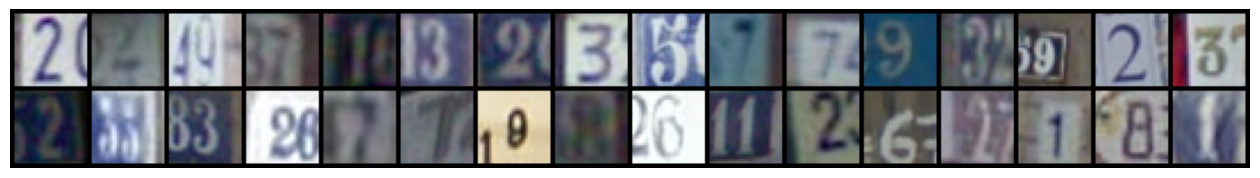

In [5]:
# Display Sample Data with Labels
for images, labels in train_loader:
    print('images.shape:', images.shape)
    print(labels)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    # needs to permute the channel to (H, W, C)
    # H: height
    # W: width
    # C: channel
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [6]:
# Define Model
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )

class ConvNet4(nn.Module):
    def __init__(self, num_channel=3, num_class=10, img_size=32):
        super().__init__()
        sz = img_size // 16
        self.encoder = nn.Sequential(
            conv_block(num_channel, 64),
            conv_block(64, 64),
            conv_block(64, 64),
            conv_block(64, 64),
            Flatten(),
            nn.Linear(sz * sz * 64, 128),
            nn.Linear(128, num_class)
        )
        self.num_class = num_class

    def forward(self, x):
        x = self.encoder(x)
        return x

    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

class Flatten(nn.Module):
    def forward(self, x): return x.view(x.size(0), -1)

In [7]:
# Evaluate Model
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [8]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [9]:
device = get_default_device()
model = ConvNet4()
to_device(model, device)

ConvNet4(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (3): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), st

In [10]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
history = [evaluate(model, val_loader)]
history += fit(10,1e-2, model, train_loader, val_loader)

Epoch [0], val_loss: 0.5052, val_acc: 0.8424
Epoch [1], val_loss: 0.3835, val_acc: 0.8866
Epoch [2], val_loss: 0.3374, val_acc: 0.9013
Epoch [3], val_loss: 0.3295, val_acc: 0.9028
Epoch [4], val_loss: 0.3230, val_acc: 0.9081
Epoch [5], val_loss: 0.3193, val_acc: 0.9091
Epoch [6], val_loss: 0.3080, val_acc: 0.9123
Epoch [7], val_loss: 0.3121, val_acc: 0.9122
Epoch [8], val_loss: 0.3193, val_acc: 0.9123
Epoch [9], val_loss: 0.3154, val_acc: 0.9116


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torch.nn.functional as F

# Define the CNN architecture
# https://docs.google.com/presentation/d/1cddUeJJ2IBlS1Jwd4Y1YDN7B8EvpG6jvt92DIe36UdI/edit?usp=sharing
class SVHNCNN(nn.Module):
    def __init__(self):
        super(SVHNCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x



# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
num_epochs = 20
batch_size = 128
learning_rate = 0.001

# Load the SVHN dataset
transform = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])

train_data = datasets.SVHN(root='./data', split='train', transform=transform, download=True)
test_data = datasets.SVHN(root='./data', split='test', transform=transform, download=True)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=True)

# Initialize the CNN
model = SVHNCNN().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    train_loss = 0
    correct = 0
    total = 0

    for batch_idx, (data, targets) in enumerate(train_loader):
        # Move data to GPU if available
        data, targets = data.to(device), targets.to(device)

        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update training loss
        train_loss += loss.item()

        # Update accuracy calculation
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    train_loss /= len(train_loader)
    train_accuracy = 100 * correct / total

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%")


# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for data, targets in test_loader:
        data, targets = data.to(device), targets.to(device)
        outputs = model(data)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    print(f"Accuracy on test set: {100 * correct / total:.2f}%")

# Save the model
torch.save(model.state_dict(), 'svhn_cnn.pth')

Using downloaded and verified file: ./data/train_32x32.mat


100%|██████████| 64275384/64275384 [00:07<00:00, 8469850.08it/s] 


Epoch [1/20], Loss: 1.0699, Accuracy: 65.91%
Epoch [2/20], Loss: 0.5149, Accuracy: 85.40%
Epoch [3/20], Loss: 0.4219, Accuracy: 87.87%
Epoch [4/20], Loss: 0.3614, Accuracy: 89.61%
Epoch [5/20], Loss: 0.3139, Accuracy: 90.91%
Epoch [6/20], Loss: 0.2751, Accuracy: 92.05%
Epoch [7/20], Loss: 0.2397, Accuracy: 93.00%
Epoch [8/20], Loss: 0.2125, Accuracy: 93.80%
Epoch [9/20], Loss: 0.1825, Accuracy: 94.72%
Epoch [10/20], Loss: 0.1590, Accuracy: 95.40%
Epoch [11/20], Loss: 0.1339, Accuracy: 96.21%
Epoch [12/20], Loss: 0.1160, Accuracy: 96.60%
Epoch [13/20], Loss: 0.0999, Accuracy: 97.00%
Epoch [14/20], Loss: 0.0839, Accuracy: 97.42%
Epoch [15/20], Loss: 0.0716, Accuracy: 97.80%
Epoch [16/20], Loss: 0.0587, Accuracy: 98.17%
Epoch [17/20], Loss: 0.0543, Accuracy: 98.35%
Epoch [18/20], Loss: 0.0460, Accuracy: 98.55%
Epoch [19/20], Loss: 0.0401, Accuracy: 98.74%
Epoch [20/20], Loss: 0.0335, Accuracy: 98.95%
Accuracy on test set: 88.07%


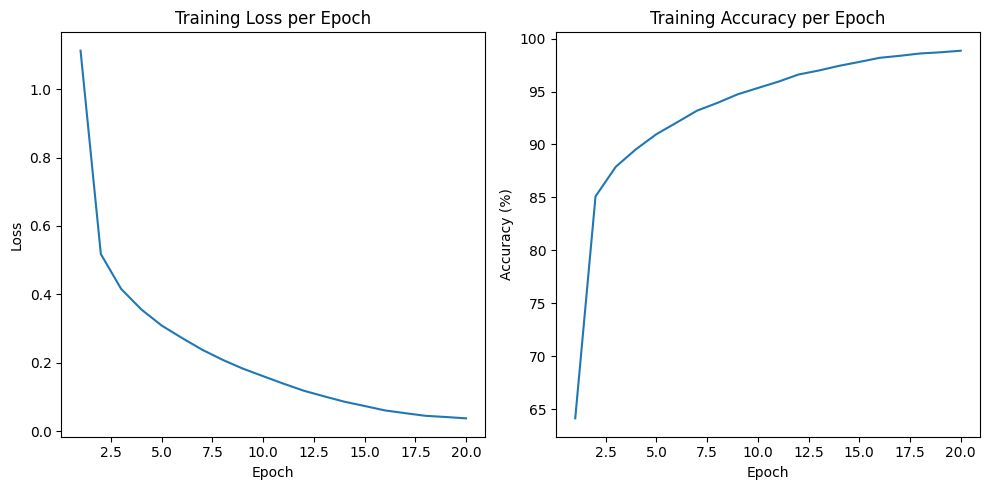

In [11]:
import re
import matplotlib.pyplot as plt

# The given text
input_text = """
Epoch [1/20], Loss: 1.1122, Accuracy: 64.15%
Epoch [2/20], Loss: 0.5180, Accuracy: 85.10%
Epoch [3/20], Loss: 0.4160, Accuracy: 87.90%
Epoch [4/20], Loss: 0.3557, Accuracy: 89.56%
Epoch [5/20], Loss: 0.3089, Accuracy: 90.97%
Epoch [6/20], Loss: 0.2726, Accuracy: 92.07%
Epoch [7/20], Loss: 0.2381, Accuracy: 93.19%
Epoch [8/20], Loss: 0.2088, Accuracy: 93.92%
Epoch [9/20], Loss: 0.1830, Accuracy: 94.73%
Epoch [10/20], Loss: 0.1609, Accuracy: 95.33%
Epoch [11/20], Loss: 0.1391, Accuracy: 95.92%
Epoch [12/20], Loss: 0.1185, Accuracy: 96.60%
Epoch [13/20], Loss: 0.1021, Accuracy: 96.98%
Epoch [14/20], Loss: 0.0864, Accuracy: 97.42%
Epoch [15/20], Loss: 0.0738, Accuracy: 97.79%
Epoch [16/20], Loss: 0.0609, Accuracy: 98.18%
Epoch [17/20], Loss: 0.0528, Accuracy: 98.37%
Epoch [18/20], Loss: 0.0451, Accuracy: 98.59%
Epoch [19/20], Loss: 0.0416, Accuracy: 98.70%
Epoch [20/20], Loss: 0.0377, Accuracy: 98.85%
"""

# Extract loss and accuracy values using regular expressions
loss_pattern = r"Loss: (\d+\.\d+)"
accuracy_pattern = r"Accuracy: (\d+\.\d+)"
loss_values = [float(x) for x in re.findall(loss_pattern, input_text)]
accuracy_values = [float(x) for x in re.findall(accuracy_pattern, input_text)]

# Plot the loss and accuracy per epoch
epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(10, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy_values)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy per Epoch')

plt.tight_layout()
plt.show()
